In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 98% 1.12G/1.14G [00:30<00:01, 20.4MB/s]
100% 1.14G/1.14G [00:30<00:00, 40.7MB/s]


In [3]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/pneumonia-xray-images"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [4]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data


In [5]:
#Define Directories for train, test & Validation Set
dataset_dir = '/content/pneumonia-xray-images'
train_path = dataset_dir+'/train'
test_path = dataset_dir+'/test'
valid_path = dataset_dir+'/val'

#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
BATCH_SIZE = 16 
#The dimension of the images we are going to define is 500x500
IMAGE_HEIGHT = 500
IMAGE_WIDTH = 500


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [7]:
train = train_data_gen.flow_from_directory(
      train_path,
      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=BATCH_SIZE
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=BATCH_SIZE
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=BATCH_SIZE
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


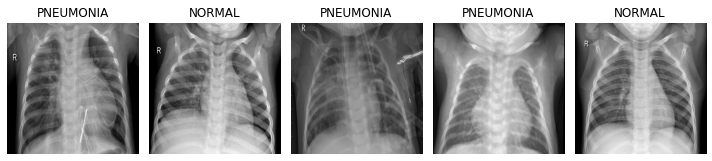

In [8]:
plt.figure(figsize=(10, 10))
for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[-1]        
        dic = {0:"NORMAL", 1:"PNEUMONIA"}
        plt.title(dic.get(Y_batch[-1]))
        plt.axis("off")
        plt.imshow(np.squeeze(image),cmap="gray")
        break
plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [10]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

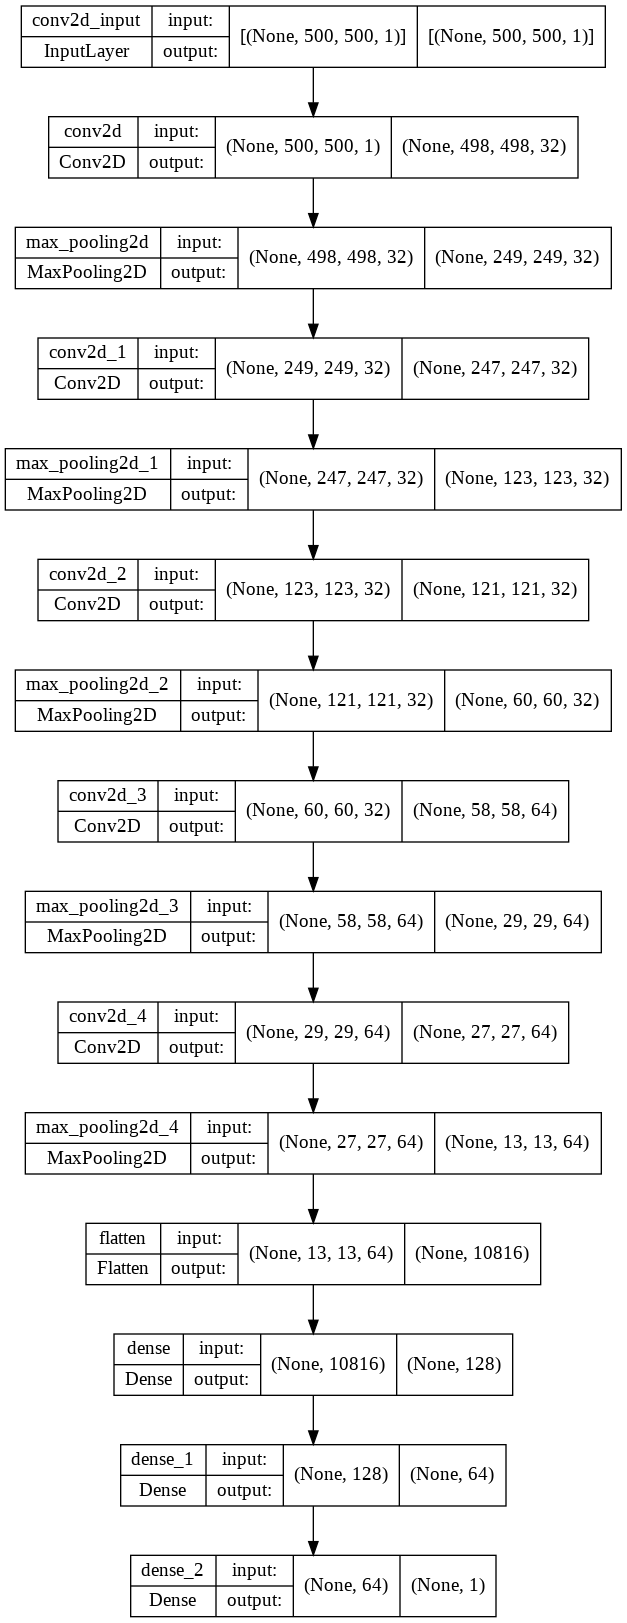

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True)

In [12]:
np.unique(train.classes)

array([0, 1], dtype=int32)

In [13]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
class_weights = dict(zip( np.unique(train.classes), weights))
print(class_weights)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [14]:
cnn.fit(
    train,
    epochs=5,
    validation_data=valid,
    class_weight=class_weights
)

Epoch 1/5
262/262 [==============================] - 68s 211ms/step - loss: 0.4052 - accuracy: 0.8177 - val_loss: 0.2219 - val_accuracy: 0.9135
Epoch 2/5
262/262 [==============================] - 63s 240ms/step - loss: 0.1315 - accuracy: 0.9497 - val_loss: 0.1206 - val_accuracy: 0.9529
Epoch 3/5
262/262 [==============================] - 60s 228ms/step - loss: 0.1076 - accuracy: 0.9602 - val_loss: 0.1549 - val_accuracy: 0.9337
Epoch 4/5
262/262 [==============================] - 56s 215ms/step - loss: 0.0830 - accuracy: 0.9692 - val_loss: 0.1101 - val_accuracy: 0.9654
Epoch 5/5
262/262 [==============================] - 55s 209ms/step - loss: 0.0584 - accuracy: 0.9759 - val_loss: 0.0827 - val_accuracy: 0.9712


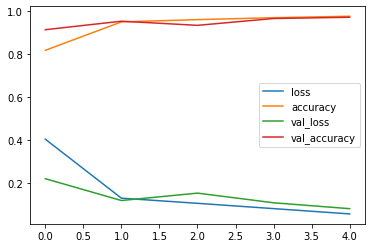

In [15]:
pd.DataFrame(cnn.history.history).plot()


In [16]:
test_accu = cnn.evaluate(test)

39/39 [==============================] - 6s 135ms/step - loss: 1.2444 - accuracy: 0.7660


In [17]:
preds = cnn.predict(test,verbose=1)


39/39 [==============================] - 5s 129ms/step


In [18]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.40      0.56       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.77      0.74       624

